# Twitter Sentiment Analysis
We will make use of the `Tweepy` API which allows us to stream tweets in real-time directly from twitter

In [46]:
import spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import re
import os
import string
import random
import nltk
from nltk.corpus import stopwords
from spacy.util import compounding
from spacy.util import minibatch
from tqdm import tqdm
from collections import Counter
from plotly import graph_objs as go
from plotly import figure_factory as ff
from plotly import express as exp
warnings.filterwarnings("ignore")

## Read the data

In [47]:
df_train = pd.read_csv("./data/train.csv")
df_test = pd.read_csv("./data/test.csv")
df_sample = pd.read_csv("./data/sample_submission.csv")

og_train = df_train

## Understand the data

In [48]:
print("Shape:")
print("Train : ", df_train.shape)
print("Test  : ", df_test.shape)

Shape:
Train :  (27481, 4)
Test  :  (3534, 3)


In [49]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   textID         27481 non-null  object
 1   text           27480 non-null  object
 2   selected_text  27480 non-null  object
 3   sentiment      27481 non-null  object
dtypes: object(4)
memory usage: 858.9+ KB


In [50]:
# since we have only one null value, we just drop it
df_train.dropna(inplace=True)

In [51]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3534 entries, 0 to 3533
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   textID     3534 non-null   object
 1   text       3534 non-null   object
 2   sentiment  3534 non-null   object
dtypes: object(3)
memory usage: 83.0+ KB


In [52]:
df_train.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [53]:
df_train.describe()

,textID,text,selected_text,sentiment
count,27480,27480,27480,27480
unique,27480,27480,22463,3
top,cb774db0d1,"I`d have responded, if I were going",good,neutral
freq,1,1,199,11117


## Distribution of tweets in the train set

In [54]:
# table
temp = df_train.groupby("sentiment").count()["text"].reset_index().sort_values(by="text", ascending=False)
temp.style.background_gradient(cmap="Blues")

,sentiment,text
1,neutral,11117
2,positive,8582
0,negative,7781


<AxesSubplot: xlabel='sentiment', ylabel='count'>

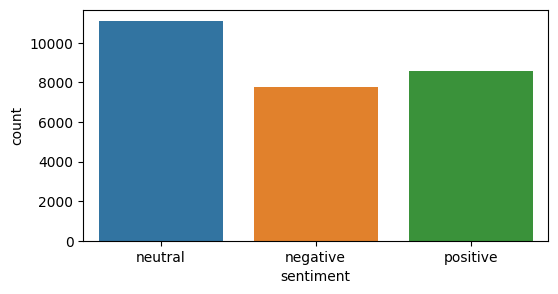

In [55]:
# bar plot
plt.figure(figsize=(6, 3))
sns.countplot(x="sentiment", data=df_train)

## Jaccard Index
The Jaccard Index is a measure of similarity between two phrases. <br>
It is defined as follows:

![jaccard_index](./images/jaccard.png)

In [56]:
def get_jaccard(str1, str2):
    a = set(str1.lower().split())
    b = set(str2.lower().split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

In [57]:
jaccard_results = []
for i, row in df_train.iterrows():
    sentence1 = row.text
    sentence2 = row.selected_text

    jaccard_score = get_jaccard(sentence1, sentence2)
    jaccard_results.append([sentence1, sentence2, jaccard_score])

jaccard = pd.DataFrame(jaccard_results, columns=["text", "selected_text", "jaccard_score"])
df_train = df_train.merge(jaccard, how="outer")
df_train.head()

,textID,text,selected_text,sentiment,jaccard_score
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286


In [58]:
df_train["num_words_text"] = df_train["text"].apply(lambda x: len(str(x).split()))
df_train["num_words_st"] = df_train["selected_text"].apply(lambda x: len(str(x).split()))
df_train["difference"] = df_train["num_words_text"] - df_train["num_words_st"]

df_train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_words_text,num_words_st,difference
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,1.000000,7,7,0
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,0.200000,10,2,8
2,088c60f138,my boss is bullying me...,bullying me,negative,0.166667,5,2,3
3,9642c003ef,what interview! leave me alone,leave me alone,negative,0.600000,5,3,2
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,0.214286,14,3,11


In [59]:
hist_data = [df_train["num_words_st"], df_train["num_words_text"]]
group_labels = ["Selected Text", "Text"]

fig = ff.create_distplot(hist_data=hist_data, group_labels=group_labels, show_curve=False)
fig.update_layout(title_text="Distribution of Number of words")
fig.update_layout(
    autosize=False,
    width=800,
    height=600,
    paper_bgcolor="Black"
)
fig.show()

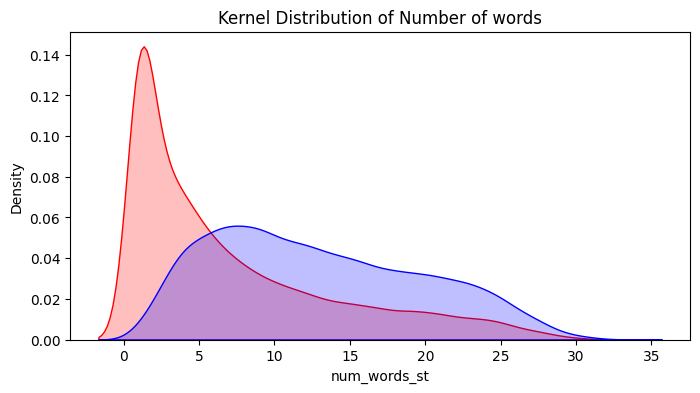

In [60]:
plt.figure(figsize=(8, 4))     
p1 = sns.kdeplot(df_train["num_words_st"], shade=True, color="r").set_title("Kernel Distribution of Number of words")
p1 = sns.kdeplot(df_train["num_words_text"], shade=True, color="b")

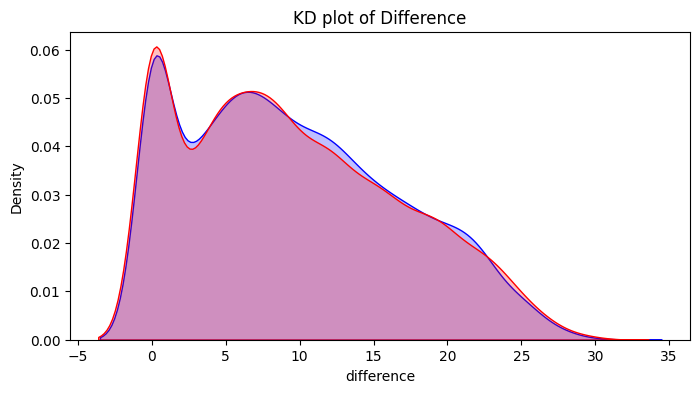

In [61]:
plt.figure(figsize=(8, 4))
p1 = sns.kdeplot(df_train[df_train["sentiment"] == "positive"]["difference"], shade=True, color="blue").set_title("KD plot of Difference")
p1 = sns.kdeplot(df_train[df_train["sentiment"] == "negative"]["difference"], shade=True, color="red")

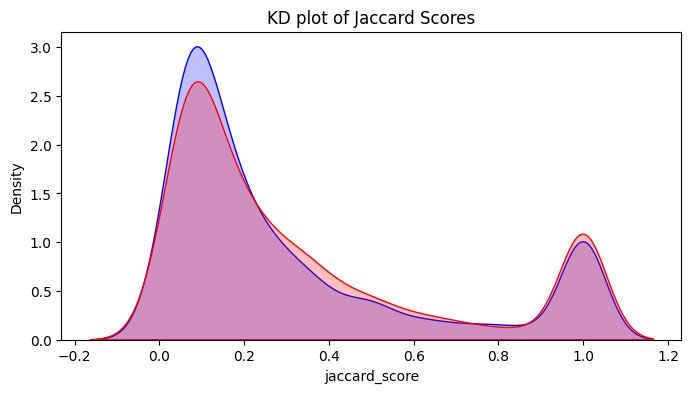

In [62]:
plt.figure(figsize=(8, 4))
p1 = sns.kdeplot(df_train[df_train["sentiment"] == "positive"]["jaccard_score"], shade=True, color="blue").set_title("KD plot of Jaccard Scores")
p1 = sns.kdeplot(df_train[df_train["sentiment"] == "negative"]["jaccard_score"], shade=True, color="red")

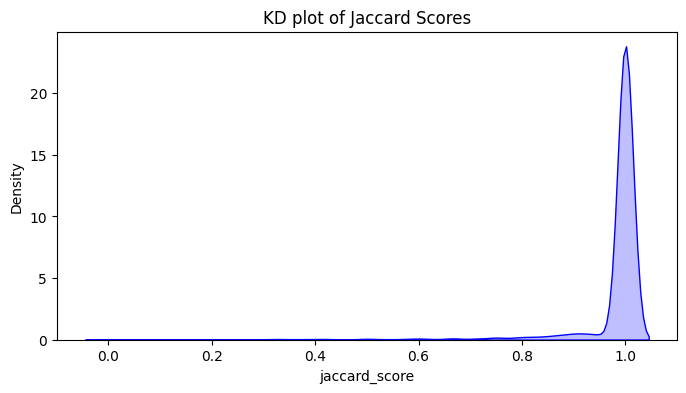

In [63]:
plt.figure(figsize=(8, 4))
p1 = sns.kdeplot(df_train[df_train["sentiment"] == "neutral"]["jaccard_score"], shade=True, color="blue").set_title("KD plot of Jaccard Scores")

## Observation
* Positive and Negative tweets have high kurtosis, and so the values are concentrated in two regions
* Neutral tweets have a low kurtosis, and their values are concentrated around 1

### Find the cluster of tweets where there is a high similarity between text and selected text

In [64]:
k = df_train[df_train["num_words_text"] < 3]
k.head()

,textID,text,selected_text,sentiment,jaccard_score,num_words_text,num_words_st,difference
7,50e14c0bb8,Soooo high,Soooo high,neutral,1.0,2,2,0
26,852edc3769,I`m sorry.,I`m sorry.,negative,1.0,2,2,0
42,2e7082d1c8,MAYDAY?!,MAYDAY?!,neutral,1.0,1,1,0
61,a4b0888da6,haha yes,haha yes,neutral,1.0,2,2,0
68,fa2654e730,Chilliin,Chilliin,positive,1.0,1,1,0


In [65]:
k.groupby("sentiment").mean()["jaccard_score"]

sentiment
negative    0.788580
neutral     0.977805
positive    0.765700
Name: jaccard_score, dtype: float64

## Clean the data

In [66]:
def clean_text(text):
    # to lowercase
    # remove text in []
    # remove links
    # remove punctuation
    # remove words containing numbers
    
    text = str(text).lower()
    text = re.sub("\[.*?\]", "", text)
    text = re.sub("https?://\S+|www\.\S+", "", text)
    text = re.sub("<.*?>+", "", text)
    text = re.sub("[%s]" % re.escape(string.punctuation), "", text)
    text = re.sub("\n", "", text)
    text = re.sub("\w*\d\w*", "", text)
    
    return text

In [67]:
df_train["text"] = df_train["text"].apply(lambda x: clean_text(x))
df_train["selected_text"] = df_train["selected_text"].apply(lambda x: clean_text(x))

In [68]:
df_train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_words_text,num_words_st,difference
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,10,2,8
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,5,2,3
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,5,3,2
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,14,3,11


## Most common words

In [69]:
def get_common_words(data):
    total_list_of_words = []
    for item in list(data["list_of_words"]):
        for word in item:
            total_list_of_words.append(word)
    top = Counter(total_list_of_words)
    most_common_words = pd.DataFrame(top.most_common(20))
    return most_common_words

df_train["list_of_words"] = df_train["selected_text"].apply(lambda x: str(x).split())
most_common = get_common_words(df_train)
most_common.style.background_gradient(cmap="Blues")

,0,1
0,i,7200
1,to,5305
2,the,4590
3,a,3538
4,my,2783
5,you,2624
6,and,2321
7,it,2158
8,is,2115
9,in,1986


## Remove stop words

In [70]:
def remove_stop_words(x):
    return [y for y in x if y not in stops]

stops = stopwords.words("english")

In [71]:
df_train["list_of_words"] = df_train["list_of_words"].apply(lambda x: remove_stop_words(x))
df_train.head()

,textID,text,selected_text,sentiment,jaccard_score,num_words_text,num_words_st,difference,list_of_words
0,cb774db0d1,id have responded if i were going,id have responded if i were going,neutral,1.000000,7,7,0,"[id, responded, going]"
1,549e992a42,sooo sad i will miss you here in san diego,sooo sad,negative,0.200000,10,2,8,"[sooo, sad]"
2,088c60f138,my boss is bullying me,bullying me,negative,0.166667,5,2,3,[bullying]
3,9642c003ef,what interview leave me alone,leave me alone,negative,0.600000,5,3,2,"[leave, alone]"
4,358bd9e861,sons of why couldnt they put them on the rel...,sons of,negative,0.214286,14,3,11,[sons]


In [72]:
most_common = get_common_words(df_train)
most_common.style.background_gradient(cmap="Blues")
most_common = most_common.iloc[1:, :]
most_common.columns = ["Common_words", "Count"]
most_common.style.background_gradient(cmap="Blues")

,Common_words,Count
1,good,1251
2,day,1058
3,love,909
4,happy,852
5,like,774
6,get,772
7,dont,765
8,go,700
9,cant,613
10,work,612


In [73]:
fig = exp.treemap(most_common, path=["Common_words"], values="Count", title="Tree of most common words")
fig.show()

In [74]:
positive = df_train[df_train.sentiment == "positive"]
negative = df_train[df_train.sentiment == "negative"]
neutral = df_train[df_train.sentiment == "neutral"]

In [75]:
most_common = get_common_words(positive)
most_common.style.background_gradient(cmap="Greens")

,0,1
0,good,826
1,happy,730
2,love,697
3,day,456
4,thanks,439
5,great,364
6,fun,287
7,nice,267
8,mothers,259
9,hope,245


In [76]:
most_common = get_common_words(negative)
most_common.style.background_gradient(cmap="Reds")

,0,1
0,im,452
1,miss,358
2,sad,343
3,sorry,300
4,bad,246
5,hate,230
6,dont,221
7,cant,201
8,sick,166
9,like,162


In [77]:
raw_text = [word for word_list in df_train["list_of_words"] for word in word_list]
raw_text[:5]

df_train[df_train.sentiment == "positive"]["list_of_words"].head()

6                                            [fun]
9                         [wow, u, became, cooler]
11                                          [like]
21                                   [interesting]
25    [free, fillin, app, ipod, fun, im, addicted]
Name: list_of_words, dtype: object

In [78]:
def get_unique_words(sentiment, num_words, raw_text):
    other = []

    for list_of_words in df_train[df_train.sentiment != sentiment]["list_of_words"]:
        for word in list_of_words:
            other.append(word)
    other = list(set(other))
    specific = [x for x in raw_text if x not in other]

    counter = Counter()
    for list_of_words in df_train[df_train.sentiment == sentiment]["list_of_words"]:
        for word in list_of_words:
            counter[word] += 1
    keep = list(specific)

    for word in list(counter):
        if word not in keep:
            del counter[word]

    unique_words = pd.DataFrame(counter.most_common(num_words), columns=["words", "count"])
    return unique_words

In [79]:
unique_positive = get_unique_words("positive", 20, raw_text=raw_text)
print("The top 20 unique positive words are:")
unique_positive.style.background_gradient(cmap="Greens")

The top 20 unique positive words are:


,words,count
0,congratulations,26
1,thnx,8
2,lov,8
3,happ,7
4,talented,7
5,brilliant,7
6,appreciated,6
7,goood,6
8,amazin,5
9,mommas,5


In [80]:
unique_negative = get_unique_words("negative", 20, raw_text=raw_text)
print("The top 20 unique negative words are:")
unique_negative.style.background_gradient(cmap="Reds")

The top 20 unique negative words are:


,words,count
0,ache,10
1,saddest,7
2,hated,6
3,weak,6
4,suffering,6
5,rly,5
6,devastated,5
7,pissing,5
8,allergic,4
9,cramps,4


# Modelling

Named Entity Recognition (NER) is a standard NLP problem which involves spotting named entities (people, places, cities etc) from a chunk of text, and classifying them into a predefined set of categories.

* We use text as selected text due to their high Jaccard similarity.
* We also use text as selected text for tweets having 3 words or fewer.
* Train 2 separate models for Positive and Negative tweets.

In [81]:
df_train = og_train
df_train["num_words_text"] = df_train.text.apply(lambda x: len(str(x).split()))
df_train = df_train[df_train.num_words_text >= 3]
df_train.head()

,textID,text,selected_text,sentiment,num_words_text
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral,7
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative,10
2,088c60f138,my boss is bullying me...,bullying me,negative,5
3,9642c003ef,what interview! leave me alone,leave me alone,negative,5
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative,14


In [82]:
def save_model(output_dir, nlp, name):
    output_dir = f"./working/{output_dir}"
    if output_dir is not None:
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        
        nlp.meta["name"] = name
        nlp.to_disk(output_dir)
        print("Saved model to ", output_dir)

In [83]:
def get_model_output_path(sentiment):
    model_output_path = None
    if sentiment == "positive":
        model_output_path = "models/model_positive"
    elif sentiment == "negative":
        model_output_path = "models/model_negative"
    return model_output_path

In [84]:
# returns train data in the format needed to train spacy NER
def format_train(sentiment):
    train_data = []

    for i, row in df_train.iterrows():
        if row.sentiment == sentiment:
            selected_text = row.selected_text
            text = row.text

            start = text.find(selected_text)
            end = start + len(selected_text)
            
            train_data.append((text, {"entities": [[start, end, "selected_text"]]}))
    return train_data

In [85]:
def train(train_data, output_dir, n_iter=20, model=None):
    """Load the model, set up the pipeline and train the entity recognizer."""
    ""
    if model is not None:
        nlp = spacy.load(output_dir)  # load existing spaCy model
        print("Loaded model '%s'" % model)
    else:
        nlp = spacy.blank("en")  # create blank Language class
        print("Created blank 'en' model")
    
    # create the built-in pipeline components and add them to the pipeline
    # nlp.create_pipe works for built-ins that are registered with spaCy
    if "ner" not in nlp.pipe_names:
        ner = nlp.add_pipe("ner", last=True)
    else:
        ner = nlp.get_pipe("ner")
    for _, annotations in train_data:
        for ent in annotations.get("entities"):
            ner.add_label(ent[2])

    other_pipes = [pipe for pipe in nlp.pipe_names if pipe != "ner"]
    with nlp.disable_pipes(*other_pipes):  # only train NER
        if model is None:
            nlp.begin_training()
        else:
            nlp.resume_training()


        for itn in tqdm(range(n_iter)):
            random.shuffle(train_data)
            batches = minibatch(train_data, size=compounding(4.0, 500.0, 1.001))    
            losses = {}
            for batch in batches:
                texts, annotations = zip(*batch)
                texts = texts[0]
                annotations = annotations[0]
                doc = nlp.make_doc(texts)
                example = spacy.training.Example.from_dict(doc, annotations)
                nlp.update([example],
                            drop=0.5,   # dropout - make it harder to memorise data
                            losses=losses, 
                            )
            print("Losses", losses)
    save_model(output_dir, nlp, "st_ner")

## Get the models

In [86]:
sentiment = "positive"
train_data = format_train(sentiment)
model_path = get_model_output_path(sentiment)
train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:32<01:04, 32.04s/it]

Losses {'ner': 2116.4068104991634}


 67%|██████▋   | 2/3 [01:04<00:32, 32.21s/it]

Losses {'ner': 1899.5102328040198}


100%|██████████| 3/3 [01:35<00:00, 31.92s/it]

Losses {'ner': 1805.504352712168}
Saved model to  ./working/models/model_positive


In [87]:
sentiment = 'negative'

train_data = format_train(sentiment)
model_path = get_model_output_path(sentiment)

train(train_data, model_path, n_iter=3, model=None)

Created blank 'en' model


 33%|███▎      | 1/3 [00:29<00:59, 29.68s/it]

Losses {'ner': 2025.3228869489635}


 67%|██████▋   | 2/3 [00:59<00:29, 29.53s/it]

Losses {'ner': 1798.8667420632294}


100%|██████████| 3/3 [01:28<00:00, 29.35s/it]

Losses {'ner': 1814.9200134557996}
Saved model to  ./working/models/model_negative


In [88]:
def predict_entities(text, model):
    doc = model(text)
    entity_array = []

    for ent in doc.ents:
        start = text.find(ent.text)
        end = start + len(ent.text)
        new_int = [start, end, ent.label_]

        if new_int not in entity_array:
            entity_array.append([start, end, ent.label_])
    
    selected_text = text[entity_array[0][0]: entity_array[0][1]] if len(entity_array) > 0 else text
    return selected_text

In [89]:
selected_texts = []
MODEL_BASE = "./working/models/"

if MODEL_BASE is not None:
    print("Loading models from ", MODEL_BASE)
    model_positive = spacy.load(MODEL_BASE + "model_positive")
    model_negative = spacy.load(MODEL_BASE + "model_negative")

    for i, row in df_test.iterrows():
        text = row.text
        output_string = ""

        if row.sentiment == "neutral" or len(text.split()) <= 2:
            selected_texts.append(text)
        elif row.sentiment == "positive":
            selected_texts.append(predict_entities(text, model_positive))
        else:
            selected_texts.append(predict_entities(text, model_negative))

df_test["selected_text"] = selected_texts

Loading models from  ./working/models/


In [90]:
df_sample["selected_text"] = df_test["selected_text"]
df_sample.to_csv("result.csv", index=False)
df_sample.head(10)

,textID,selected_text
0,f87dea47db,Last session of the day http://twitpic.com/67ezh
1,96d74cb729,Shanghai is also really exciting (precisely -...
2,eee518ae67,"Recession hit Veronique Branquinho, she has to..."
3,01082688c6,happy bday!
4,33987a8ee5,http://twitpic.com/4w75p - I like it!!
5,726e501993,that`s great!! weee!! visitors!
6,261932614e,I THINK EVERYONE HATES ME ON HERE lol
7,afa11da83f,"soooooo wish i could, but im in school and my..."
8,e64208b4ef,and within a short time of the last clue all ...
9,37bcad24ca,What did you get? My day is alright.. haven`...
